In [43]:
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

### Login huggingface hub

In [44]:
from huggingface_hub import login
from dotenv import load_dotenv
import os

load_dotenv()
login(os.getenv('HUGGINGFACE_TOKEN'))

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/daniele/.cache/huggingface/token
Login successful


### Downlaod dataset

In [45]:
from datasets import load_dataset

DATASET_RAW = "hugginglearners/data-science-job-salaries"

#dataset = load_dataset(DATASET_RAW, split="train")


In [46]:
import pandas as pd

#dataset = pd.DataFrame(dataset).drop(columns=['Unnamed: 0'])
dataset = pd.read_csv('dataset/salaries.csv')
dataset.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Data Strategist,242000,USD,242000,US,0,US,M
1,2023,SE,FT,Data Strategist,106200,USD,106200,US,0,US,M
2,2023,MI,FT,Machine Learning Engineer,165000,USD,165000,US,0,US,M
3,2023,MI,FT,Machine Learning Engineer,135000,USD,135000,US,0,US,M
4,2023,EN,FT,Data Analyst,75065,USD,75065,US,100,US,M


In [47]:
dataset.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,10425.000000,1.042500e+04,10425.000000,10425.000000
mean,2022.778225,1.706057e+05,149338.970743,36.513189
std,0.507546,4.202013e+05,65268.905730,47.585358
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2023.000000,1.050000e+05,104663.000000,0.000000
50%,2023.000000,1.430000e+05,142200.000000,0.000000
75%,2023.000000,1.886000e+05,185900.000000,100.000000
max,2023.000000,3.040000e+07,750000.000000,100.000000


In [48]:
dataset['salary'].describe()

count    1.042500e+04
mean     1.706057e+05
std      4.202013e+05
min      1.400000e+04
25%      1.050000e+05
50%      1.430000e+05
75%      1.886000e+05
max      3.040000e+07
Name: salary, dtype: float64

# Feature engineering

We will use only the salary in USD dollars, so we will drop the other column. Also, we will drop **employee_residence** and **remote_ratio** to reduce the number of useless features.

In [49]:
dataset['salary'] = dataset['salary_in_usd']
dataset.drop(columns=['salary_in_usd','employee_residence', 'remote_ratio'], inplace=True)

In [50]:
dataset.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,company_location,company_size
0,2023,SE,FT,Data Strategist,242000,USD,US,M
1,2023,SE,FT,Data Strategist,106200,USD,US,M
2,2023,MI,FT,Machine Learning Engineer,165000,USD,US,M
3,2023,MI,FT,Machine Learning Engineer,135000,USD,US,M
4,2023,EN,FT,Data Analyst,75065,USD,US,M


In [51]:
salary_currency_map = {
    'USD': 0,
    'EUR': 1,
    'GBP': 2,
    'other_currency': 3
}

dataset['salary_currency'] = dataset['salary_currency'].map(lambda x: salary_currency_map.get(x, 3))
dataset.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,company_location,company_size
0,2023,SE,FT,Data Strategist,242000,0,US,M
1,2023,SE,FT,Data Strategist,106200,0,US,M
2,2023,MI,FT,Machine Learning Engineer,165000,0,US,M
3,2023,MI,FT,Machine Learning Engineer,135000,0,US,M
4,2023,EN,FT,Data Analyst,75065,0,US,M


### Experience level

We will map the experience level to a number, so we can use it in the model.

In [52]:
dataset['experience_level'].value_counts()

experience_level
SE    7313
MI    2175
EN     640
EX     297
Name: count, dtype: int64

In [53]:
experience_level_map = {
    'EN': 0,
    'MI': 1,
    'SE': 2,
    'EX': 3
}

dataset['experience_level'] = dataset['experience_level'].map(experience_level_map)
dataset.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,company_location,company_size
0,2023,2,FT,Data Strategist,242000,0,US,M
1,2023,2,FT,Data Strategist,106200,0,US,M
2,2023,1,FT,Machine Learning Engineer,165000,0,US,M
3,2023,1,FT,Machine Learning Engineer,135000,0,US,M
4,2023,0,FT,Data Analyst,75065,0,US,M


<Axes: xlabel='job_title'>

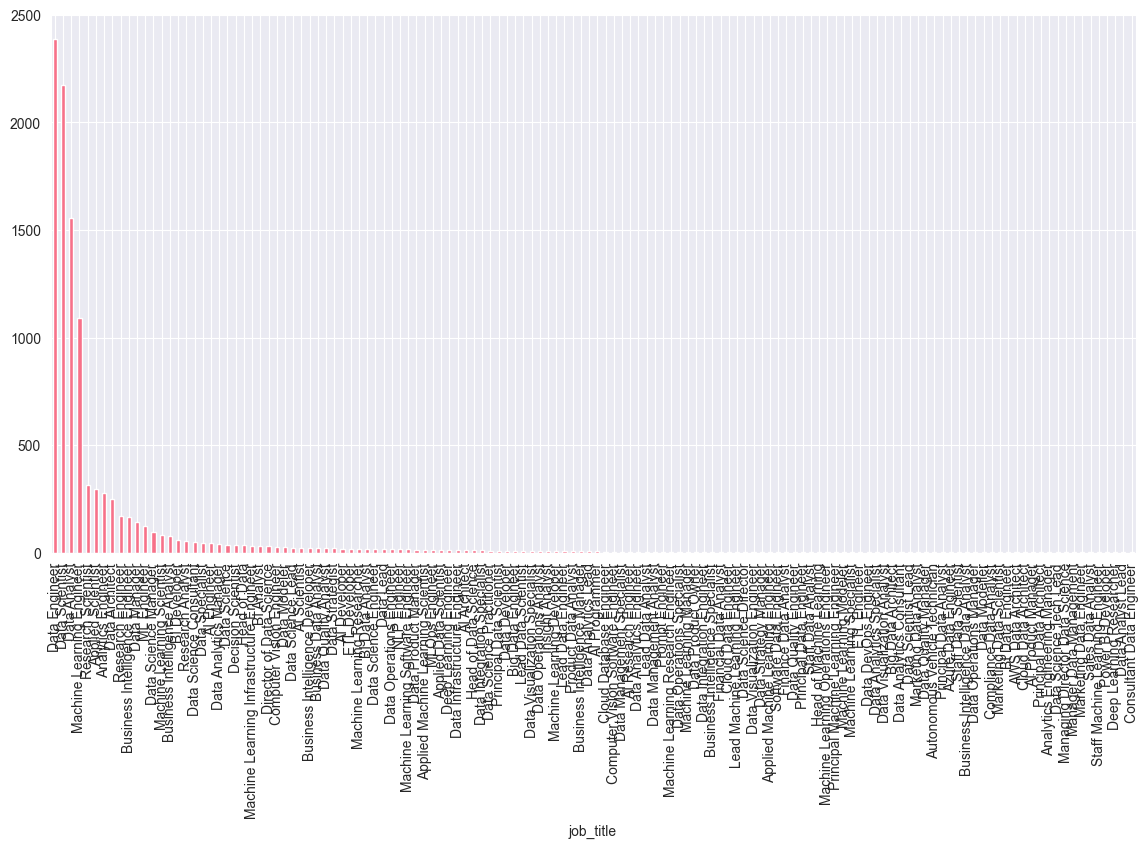

In [54]:
dataset['job_title'].value_counts().plot.bar(figsize=(14, 7))

#### Employment type

In [55]:
dataset['employment_type'].value_counts()

employment_type
FT    10379
CT       19
PT       15
FL       12
Name: count, dtype: int64

We will use only the full time jobs, so we will drop the other rows. And so drop the column.

In [56]:
dataset = dataset[dataset['employment_type'] == 'FT'].drop(columns=['employment_type'])
dataset.head()

,work_year,experience_level,job_title,salary,salary_currency,company_location,company_size
0,2023,2,Data Strategist,242000,0,US,M
1,2023,2,Data Strategist,106200,0,US,M
2,2023,1,Machine Learning Engineer,165000,0,US,M
3,2023,1,Machine Learning Engineer,135000,0,US,M
4,2023,0,Data Analyst,75065,0,US,M


#### Company size

In [57]:
dataset['company_size'].value_counts()

company_size
M    9402
L     824
S     153
Name: count, dtype: int64

In [58]:
company_size_map = {
    'S': 0,
    'M': 1,
    'L': 2,
}

dataset['company_size'] = dataset['company_size'].map(company_size_map)

### Company location

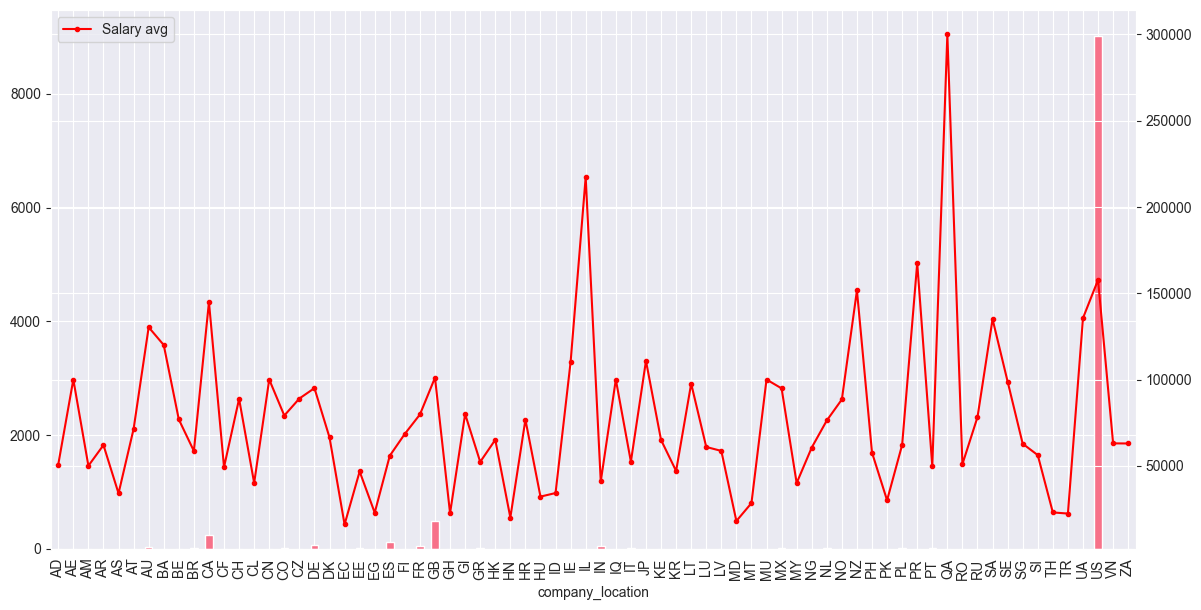

In [59]:
salary_avg = dataset.groupby('company_location', as_index=False)['salary'].mean().rename(columns={'salary': 'salary_avg'})

ax = dataset['company_location'].value_counts().sort_index().plot.bar( figsize=(14, 7))
ax2 = ax.twinx()
ax2.plot(salary_avg['company_location'],salary_avg['salary_avg'], color='r', marker='o', markersize=3)
ax2.legend(['Salary avg'], loc='upper left')

#### CPI (Consumer Price Index)
The consumer price index (CPI) measures the average price change of all goods and services purchased by households for consumption purposes, e.g. food, clothing, motor vehicles, rents, cleaning services, repairs, etc.

We will take the data of the specific year of the job offer.

In [78]:
import requests

def get_gdp_by_country_code(country_code, year=2023, index='FP.CPI.TOTL'):
    # World Bank API endpoint for GDP data
    api_url = f'http://api.worldbank.org/v2/country/{country_code}/indicator/{index}?data={year}&format=json'


    # Make a GET request to the API
    response = requests.get(api_url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

        # Extract the GDP value from the response
        gdp_value = data[1][0]['value'] if data[1] else None

        return gdp_value
    else:
        # If the request was not successful, print an error message
        print(f"Error: Unable to fetch data. Status code: {response.status_code}")
        return None

In [80]:
country_CPI = dataset[['work_year','company_location']].drop_duplicates()

country_CPI['CPI'] = country_CPI.apply(lambda x: get_gdp_by_country_code(x['company_location'], x['work_year']), axis=1)
country_CPI.head()

,work_year,company_location,CPI
0,2023,US,134.211206
14,2023,GB,133.660070
26,2023,DE,124.489744
56,2023,CA,129.858329
222,2023,HU,151.411886


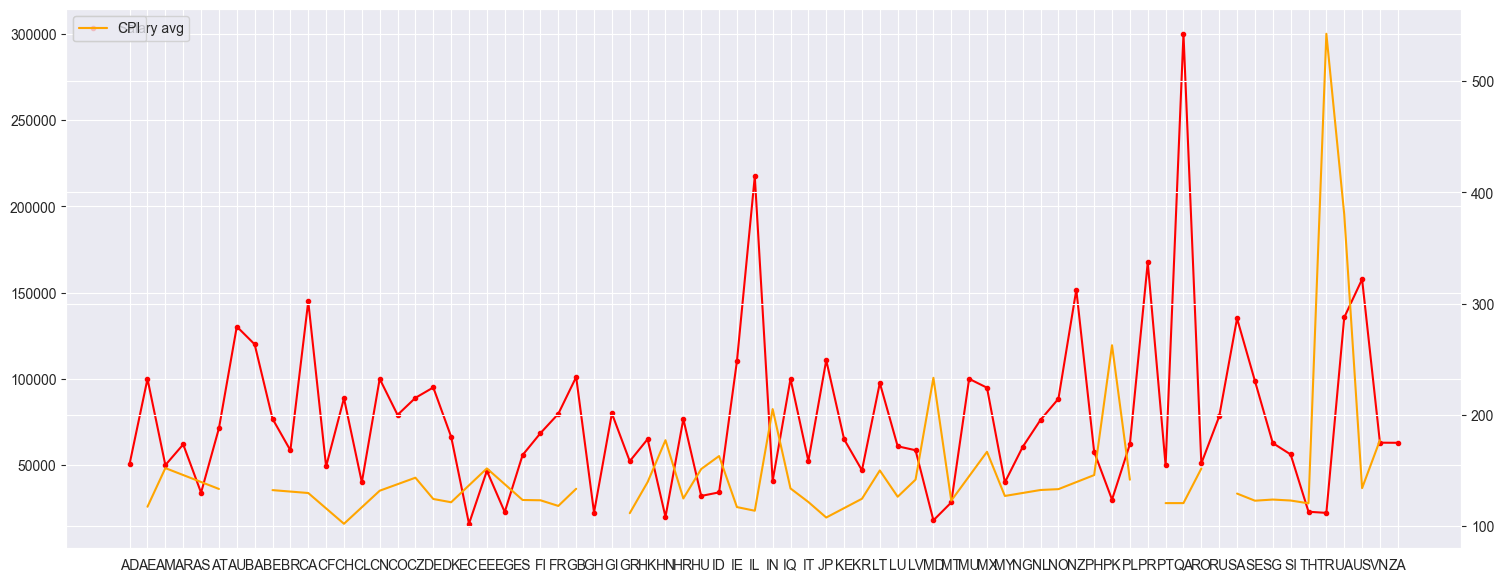

In [81]:
ax = plt.figure(figsize=(18, 7)).gca()
country_CPI = country_CPI.sort_values(by=['company_location'])

cpi_avg = country_CPI.groupby('company_location', as_index=False)['CPI'].mean().rename(columns={'CPI': 'CPI_avg'})

ax.plot(salary_avg['company_location'],salary_avg['salary_avg'], color='r', marker='o', markersize=3)

ax.legend(['Salary avg'], loc='upper left')

ax3 = ax.twinx()
ax3.plot(cpi_avg['company_location'],cpi_avg['CPI_avg'], color='orange')
ax3.legend(['CPI'], loc='upper left')

#### Check if make sense to group by continent

In [82]:
import pycountry_convert as pc

dataset['company_continent'] = dataset['company_location'].apply(lambda x: pc.country_alpha2_to_continent_code(x))

<Axes: xlabel='company_continent'>

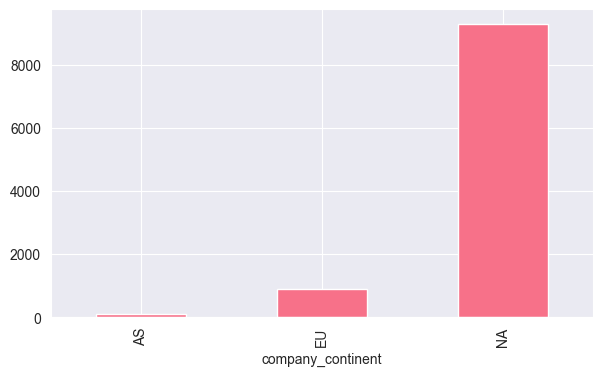

In [83]:
dataset['company_continent'].value_counts().sort_index().plot.bar( figsize=(7,4))

We can see that the majority of the companies are in EU, NA and AS. So we will exclude the other continents, since we don't have enough data.

In [84]:
dataset = dataset[dataset['company_continent'].isin(['EU', 'NA', 'AS'])]

### Salary avg inside europe

In [85]:
salary_avg_europe = dataset.where(dataset['company_continent'] == 'EU').groupby('company_location', as_index=False)['salary'].mean().rename(columns={'salary': 'salary_avg'})
salary_avg_europe.describe()

,salary_avg
count,33.000000
mean,71927.859583
std,26095.766361
min,18000.000000
25%,52357.750000
50%,71354.833333
75%,88769.833333
max,135600.000000


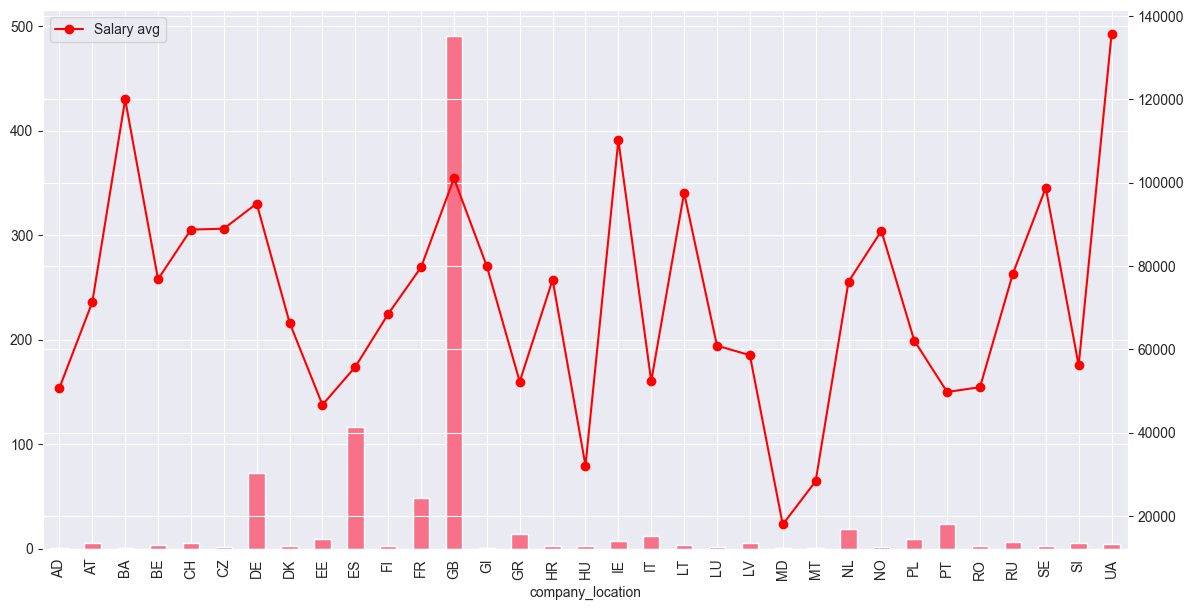

In [86]:
ax = dataset.where(dataset['company_continent'] == 'EU')['company_location'].value_counts().sort_index().plot.bar( figsize=(14, 7))
ax2 = ax.twinx()
ax2.plot(salary_avg_europe['salary_avg'], color='r', marker='o')
ax2.legend(['Salary avg'], loc='upper left')

### Correlation between salary and CPI in europe

In [87]:
salary_avg_europe_se = dataset.where(dataset['company_continent'] == 'EU')\
                              .where(dataset['company_location'].isin(country_CPI.dropna().company_location))\
                              .groupby(['company_location', 'experience_level'], as_index=False)['salary'].mean().rename(columns={'salary': 'salary_avg'})
len(salary_avg_europe_se)

73

In [88]:
salary_avg_europe_se['CPI']= salary_avg_europe_se['company_location'].apply(lambda x: country_CPI[country_CPI.company_location == x].CPI.values[0])
salary_avg_europe_se.dropna(inplace=True)
salary_avg_europe_se.notnull().sum()

company_location    73
experience_level    73
salary_avg          73
CPI                 73
dtype: int64

In [89]:
#calculate the correlation coefficient with CPI
from scipy.stats import pearsonr
results =[]
for exp in salary_avg_europe_se.experience_level.unique():
    corr, p_value = pearsonr(salary_avg_europe_se[salary_avg_europe_se.experience_level == exp]['CPI'], salary_avg_europe_se[salary_avg_europe_se.experience_level == exp]['salary_avg'])
    variance = salary_avg_europe_se[salary_avg_europe_se.experience_level == exp]['salary_avg'].var()
    n_samples = salary_avg_europe_se[salary_avg_europe_se.experience_level == exp]['salary_avg'].count()
    results.append({'experience_level': exp, 'corr': corr, 'variance': variance, 'n_samples': n_samples, 'p_value': p_value})

results = pd.DataFrame(results)
results

,experience_level,corr,variance,n_samples,p_value
0,0.0,-0.010246,4.792295e+08,17,0.968867
1,1.0,-0.481634,5.118245e+08,26,0.012727
2,2.0,0.440246,1.010298e+09,24,0.031322
3,3.0,0.544752,1.239478e+09,6,0.263701


#### Correlation between salary and CPI worldwide

In [90]:
salary_avg_se = dataset.where(dataset['company_location'].isin(country_CPI.dropna().company_location))\
                              .groupby(['company_location', 'experience_level'], as_index=False)['salary'].mean().rename(columns={'salary': 'salary_avg'})
len(salary_avg_se)

119

In [91]:
salary_avg_se['CPI']= salary_avg_se['company_location'].apply(lambda x: country_CPI[country_CPI.company_location == x].CPI.values[0])
salary_avg_se.dropna(inplace=True)
salary_avg_se.notnull().sum()

company_location    119
experience_level    119
salary_avg          119
CPI                 119
dtype: int64

In [92]:
#calculate the correlation coefficient with CPI

results =[]
for exp in salary_avg_se.experience_level.unique():
    corr, p_value = pearsonr(salary_avg_se[salary_avg_se.experience_level == exp]['CPI'], salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'])
    variance = salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'].var()
    n_samples = salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'].count()

    results.append({'experience_level': exp, 'corr': corr, 'variance': variance, 'n_samples': n_samples, 'p_value': p_value})

results = pd.DataFrame(results)
results

,experience_level,corr,variance,n_samples,p_value
0,1.0,-0.279966,2.075317e+09,45,0.062510
1,2.0,-0.157436,2.652187e+09,34,0.373880
2,0.0,-0.247176,7.321358e+08,30,0.187886
3,3.0,-0.415519,1.834296e+09,10,0.232399


From the result above, we can see that the correlation between salary and CPI is medium, and the variance is high. Also, the correlation is negative, which means that the higher the CPI, the lower the salary. This is not what we expected!

### Correlation between salary and GDP worldwide

In [93]:
country_GDP = dataset[['work_year','company_location']].drop_duplicates()
country_GDP['GDP'] = country_CPI.apply(lambda x: get_gdp_by_country_code(x['company_location'], x['work_year'], index='NY.GDP.MKTP.CD'), axis=1)
country_GDP.head()

,work_year,company_location,GDP
0,2023,US,2.543970e+13
14,2023,GB,3.089073e+12
26,2023,DE,4.082469e+12
56,2023,CA,2.137939e+12
222,2023,HU,1.773374e+11


In [94]:
salary_avg_se['GDP']= salary_avg_se['company_location'].apply(lambda x: country_GDP[country_GDP.company_location == x].GDP.values[0])

salary_avg_se.notnull().sum()

company_location    119
experience_level    119
salary_avg          119
CPI                 119
GDP                 119
dtype: int64

In [95]:
#calculate the correlation coefficient with GDP

results =[]
for exp in salary_avg_se.experience_level.unique():
    corr, p_value = pearsonr(salary_avg_se[salary_avg_se.experience_level == exp]['GDP'], salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'])
    variance = salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'].var()
    n_samples = salary_avg_se[salary_avg_se.experience_level == exp]['salary_avg'].count()

    results.append({'experience_level': exp, 'corr': corr, 'variance': variance, 'n_samples': n_samples, 'p_value': p_value})

results = pd.DataFrame(results)
results

,experience_level,corr,variance,n_samples,p_value
0,1.0,0.191699,2.075317e+09,45,0.207125
1,2.0,0.333210,2.652187e+09,34,0.054143
2,0.0,0.487181,7.321358e+08,30,0.006325
3,3.0,0.650707,1.834296e+09,10,0.041601


## Build final dataset

In [96]:
continent_map = {
    'EU': 0,
    'NA': 1,
    'AS': 2,
}

In [97]:
dataset.head()

,work_year,experience_level,job_title,salary,salary_currency,company_location,company_size,company_continent
0,2023,2,Data Strategist,242000,0,US,1,NA
1,2023,2,Data Strategist,106200,0,US,1,NA
2,2023,1,Machine Learning Engineer,165000,0,US,1,NA
3,2023,1,Machine Learning Engineer,135000,0,US,1,NA
4,2023,0,Data Analyst,75065,0,US,1,NA


In [104]:
dataset_final = dataset.merge(country_CPI, on=['company_location','work_year'], how='left')
dataset_final = dataset_final.merge(country_GDP, on=['company_location','work_year'], how='left')
dataset_final['Manager'] = dataset_final['job_title'].apply(lambda x: 1 if 'manager' in x.lower() else 0)
dataset_final['Engineer'] = dataset_final['job_title'].apply(lambda x: 1 if 'engineer' in x.lower() else 0)
dataset_final['Principal'] = dataset_final['job_title'].apply(lambda x: 1 if 'principal' in x.lower() else 0)
dataset_final['company_continent'] = dataset_final['company_continent'].map(continent_map)

dataset_final.drop(columns=['company_location', 'job_title', 'work_year'], inplace=True)
dataset_final.dropna(inplace=True)
dataset_final.head()

,experience_level,salary,salary_currency,company_size,company_continent,CPI,GDP,Manager,Engineer,Principal
0,2,242000,0,1,1,134.211206,2.543970e+13,0,0,0
1,2,106200,0,1,1,134.211206,2.543970e+13,0,0,0
2,1,165000,0,1,1,134.211206,2.543970e+13,0,1,0
3,1,135000,0,1,1,134.211206,2.543970e+13,0,1,0
4,0,75065,0,1,1,134.211206,2.543970e+13,0,0,0


<Axes: >

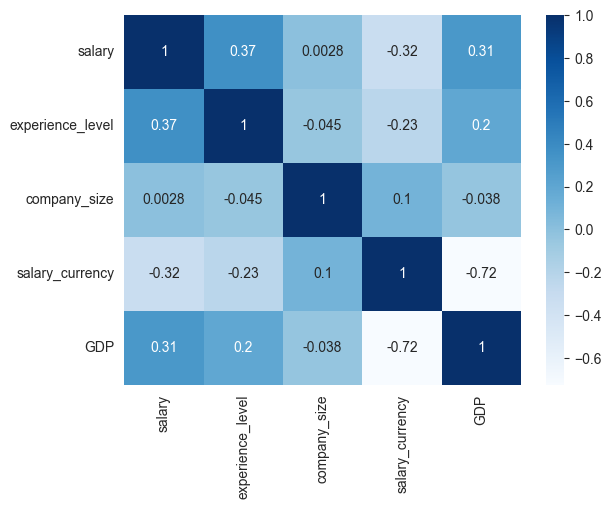

In [115]:
## Correlarion matrix

df = dataset_final[['salary', 'experience_level', 'company_size','salary_currency', 'GDP']].dropna()  #'CPI', 'GDP', 'Manager', 'Engineer', 'Principal',
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True, cmap='Blues')

### Implement SVM classification

Split the salary into 5 classes: We will use the 5 classes to train a SVM classifier.

In [116]:
salary_bins = pd.qcut(dataset_final['salary'], q=4, labels=False)
salary_bins.value_counts()

salary
0    2575
2    2572
3    2563
1    2561
Name: count, dtype: int64

In [117]:
dataset_final['salary_bins'] = salary_bins

In [118]:
from sklearn.svm import SVC as SVMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
#add grid search
from sklearn.model_selection import GridSearchCV


X = dataset_final.drop(columns=['salary', 'salary_bins'])
y = salary_bins

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

classifier = Pipeline([
  ("scaler", StandardScaler()),
  ("classifier", SVMClassifier())
])

param_grid = {
    'classifier__kernel': ['rbf', 'poly', 'sigmoid'],
    'classifier__C': [0.1, 1, 10, 100],
}

grid_search = GridSearchCV(classifier, param_grid, cv=4, verbose=3, n_jobs=2)

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


0.3849148418491484

Text(0.5, 1.0, 'Permutation Importances (test set)')

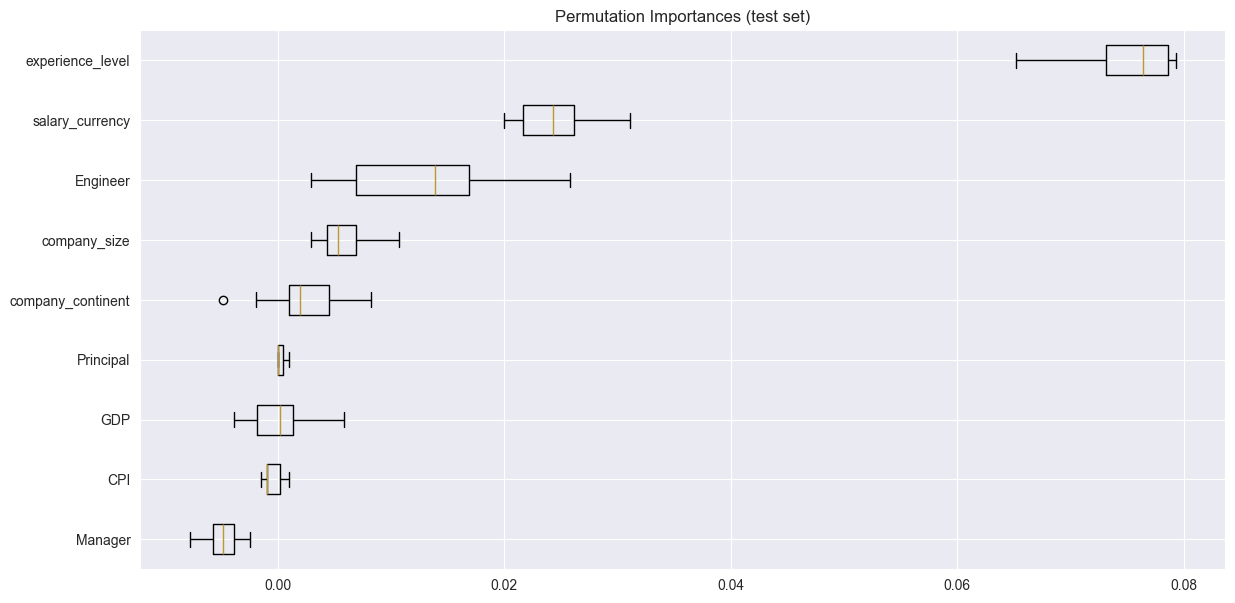

In [120]:
#Show the importance of the features
from sklearn.inspection import permutation_importance

result = permutation_importance(grid_search, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(14, 7))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

### GXBoost classification


In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
#add grid search



X = dataset_final.drop(columns=['salary', 'salary_bins'])
y = salary_bins

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#normalize dataset to improve accuracy



classifier = Pipeline([

  ("scaler", StandardScaler()),
  ("classifier", XGBClassifier(objective='multi:softmax', n_estimators=100, max_depth=15, learning_rate=0.1))
])

param_grid = {
    'classifier__max_depth': [3, 5, 10, 50, 100],
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__n_estimators': [100, 200, 500],
    'classifier__objective': ['multi:softmax', 'multi:softprob']
}

grid_search = GridSearchCV(classifier, param_grid, cv=3, verbose=3, n_jobs=2)

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

### Implement linear CLassifier

In [110]:
from sklearn.linear_model import LogisticRegression

X = dataset_final.drop(columns=['salary', 'salary_bins'])
y = salary_bins

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

classifier = Pipeline([
  ("scaler", StandardScaler()),
  ("classifier", LogisticRegression())
])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100, 1000],
}

grid_search = GridSearchCV(classifier, param_grid, cv=4, verbose=3, n_jobs=2)

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


0.4004866180048662

<Axes: >

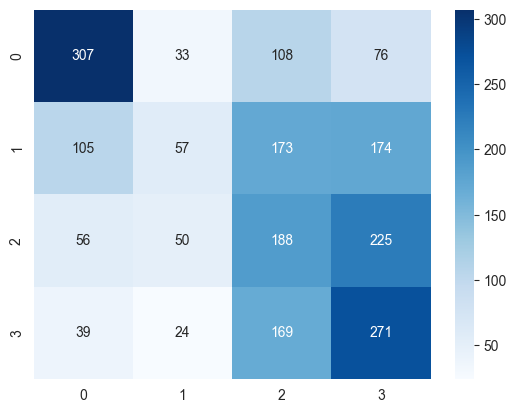

In [113]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

In [112]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier(n_jobs=4,
                      booster='gbtree',
                      objective='multi:softmax',
                      normalize_type= 'forest',
                      device='gpu')

model.fit(X_train, y_train,verbose = True)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

/Users/daniele/KTH-Projects/ID2223-Project/venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:20:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "normalize_type" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 40.05%


### Save the dataset to hopsworks

In [ ]:
import hopsworks
project = hopsworks.login()
fs = project.get_feature_store()

In [ ]:
dataset_final['job_title'] = dataset['job_title']
dataset_final.rename(columns={'salary': 'salary_USD'}, inplace=True)
dataset_final.head()